In [1]:
get_ipython().magic(u'matplotlib inline')
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np


/home/luigi/Desktop/my_lab/UNI/SaP_Master/UT/Q4/CDA/penv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

def string_to_timestamp(date_string):#convert time string to float value
    time_stamp = time.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return time.mktime(time_stamp)


In [3]:
def aggregate(before_aggregate, aggregate_feature):
    if aggregate_feature == 'day':
        after_aggregate = []
        pos_date = -1
        before_aggregate.sort(key = itemgetter(9))#sort by timestamp
        temp = groupby(before_aggregate, itemgetter(-2))
        group_unit = []
        mean = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(jtem)
            #for feature_i in xrange(6):
            #    mean.append(zip(group_unit)[feature_i])
            #after_aggregate.append(group_unit)
            after_aggregate.append(mean)
            group_unit = []
        #print after_aggregate[0]
        #print before_aggregate[0]
    if aggregate_feature == 'client':
        after_aggregate = []
        pos_client = -3
        before_aggregate.sort(key = itemgetter(pos_client))#sort with cardID firstly，if sort with 2 feature, itemgetter(num1,num2)
        temp = groupby(before_aggregate, itemgetter(pos_client))#group
        group_unit = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(jtem)
            after_aggregate.append(group_unit)
            group_unit = []
    return after_aggregate

In [4]:
def aggregate_mean(before_aggregate):
    #print before_aggregate[0]
    if True:
        after_aggregate = []
        pos_date = -1
        before_aggregate.sort(key = itemgetter(-1))#sort by timestamp
        temp = groupby(before_aggregate, itemgetter(-1))
        group_unit = []
        mean = []
        for i, item in temp:# i is group id
            for jtem in item:# unit in each group
                group_unit.append(list(jtem))
            #print group_unit
            if len(zip(group_unit)) < 2:
                after_aggregate.append(group_unit)
                group_unit = []
            if len(zip(group_unit)) >= 2:
                #print zip(group_unit)
                for feature_i in xrange(14):
                    #print zip(group_unit)[feature_i]
                    mean.append(sum(zip(*group_unit)[feature_i])/len(zip(group_unit)))
                after_aggregate.append(mean)
                group_unit = []
                mean = []
        #print after_aggregate[0]
        #print before_aggregate[0]
    return after_aggregate

In [5]:
src = 'data_for_student_case.csv'
ah = open(src, 'r')
x = []#contains features
y = []#contains labels
data = []
color = []
(issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in xrange(10)]
(issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in xrange(10)]
#label_set
#cvcresponse_set = set()
ah.readline()#skip first line
for line_ah in ah:
    if line_ah.strip().split(',')[9]=='Refused':# remove the row with 'refused' label, since it's uncertain about fraud
        continue
    if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
        continue
    bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])# date reported flaud
    issuercountry = line_ah.strip().split(',')[2]#country code
    issuercountry_set.add(issuercountry)
    txvariantcode = line_ah.strip().split(',')[3]#type of card: visa/master
    txvariantcode_set.add(txvariantcode)
    issuer_id = float(line_ah.strip().split(',')[4])#bin card issuer identifier
    amount = float(line_ah.strip().split(',')[5])#transaction amount in minor units
    currencycode = line_ah.strip().split(',')[6]
    currencycode_set.add(currencycode)
    shoppercountry = line_ah.strip().split(',')[7]#country code
    shoppercountry_set.add(shoppercountry)
    interaction = line_ah.strip().split(',')[8]#online transaction or subscription
    interaction_set.add(interaction)
    if line_ah.strip().split(',')[9] == 'Chargeback':
        label = 1#label fraud
    else:
        label = 0#label save
    verification = line_ah.strip().split(',')[10]#shopper provide CVC code or not
    verification_set.add(verification)
    cvcresponse = line_ah.strip().split(',')[11]#0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
    if cvcresponse > 2:
        cvcresponse = 3
    year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').year
    month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').month
    day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').day
    creationdate = str(year_info)+'-'+str(month_info)+'-'+str(day_info)#Date of transaction 
    creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])#Date of transaction-time stamp
    accountcode = line_ah.strip().split(',')[13]#merchant’s webshop
    accountcode_set.add(accountcode)
    mail_id = int(float(line_ah.strip().split(',')[14].replace('email','')))#mail
    mail_id_set.add(mail_id)
    ip_id = int(float(line_ah.strip().split(',')[15].replace('ip','')))#ip
    ip_id_set.add(ip_id)
    card_id = int(float(line_ah.strip().split(',')[16].replace('card','')))#card
    card_id_set.add(card_id)
    data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                 accountcode, mail_id, ip_id, card_id, label, creationdate])# add the interested features here
    #y.append(label)# add the labels
data = sorted(data, key = lambda k: k[-1]) # Sort by date

In [6]:
verification_set

{'FALSE', 'NA', 'TRUE'}

(-34.0, 714.0, -0.05500000000000001, 0.05500000000000001)

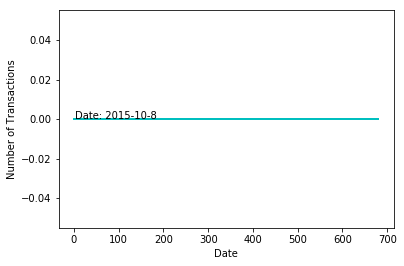

In [7]:
day_aggregate = aggregate(data,'day')
client_aggregate = aggregate(data,'client')
transaction_num_day = []
for item in day_aggregate:
    transaction_num_day.append(len(item))
plt.figure(1)
plt.plot(transaction_num_day, color = 'c', linewidth = 2)
plt.plot()
plt.text(2,0.0,'Date: 2015-10-8')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xlim([0,125])
plt.axis('tight')

(-10527.050000000001, 221068.05, -4.65, 119.65)

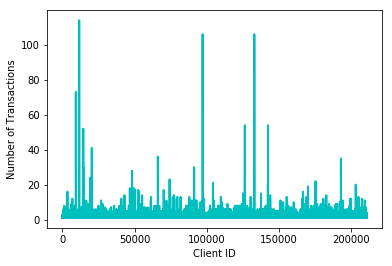

In [8]:
transaction_num_client = []
for item in client_aggregate:
    transaction_num_client.append(len(item))
plt.figure(2)
plt.plot(transaction_num_client, color = 'c', linewidth = 2)
#plt.text(99,9668,'Date: 2015-10-8')
plt.xlabel('Client ID')
plt.ylabel('Number of Transactions')
plt.axis('tight')

In [9]:
def plot_good_bad(feature_x,feature_y):
    x_good = []
    y_good = []
    x_fraud = []
    y_fraud = []
    for e in data:
        if e[-2] == 0:
            x_good.append(e[feature_x])
            y_good.append(e[feature_y])
        else:
            x_fraud.append(e[feature_x])
            y_fraud.append(e[feature_y])

    plt.plot(x_good, y_good, 'b.')
    plt.plot(x_fraud,y_fraud, 'r.')

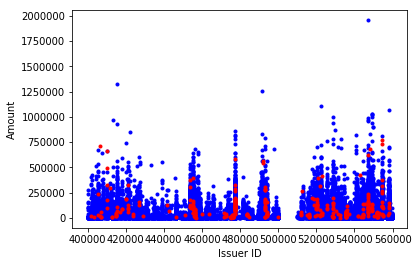

In [10]:

plot_good_bad(2,3)
plt.xlabel('Issuer ID')
plt.ylabel('Amount')
plt.show()


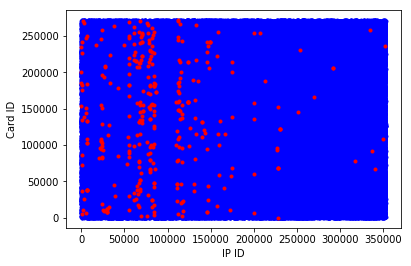

In [11]:
plot_good_bad(-4,-3)
plt.xlabel('IP ID')
plt.ylabel('Card ID')
plt.show()

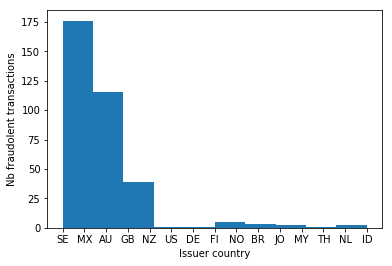

In [12]:
issuer_country = []
for e in data:
    if e[-2] == 1:
        issuer_country.append(e[0])

plt.hist(issuer_country)
plt.xlabel('Issuer country')
plt.ylabel('Nb fraudolent transactions')
plt.show()

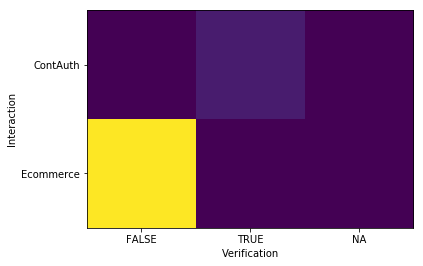

In [13]:
# Heat map interaction (6), verification (7)
d = {key: {} for key in interaction_set}
for k in d.keys():
    d[k] = {key: 0 for key in verification_set}

for e in data:
    if e[-2] == 0:
        continue
    d[e[6]][e[7]] += 1

l = [[v2 for v2 in v1.values() ] for v1 in d.values()]
i = plt.imshow(l, interpolation='nearest')

plt.gca().set_xticks([0,1,2])
plt.gca().set_yticks([0,1])
plt.gca().set_xticklabels(verification_set)
plt.gca().set_yticklabels(interaction_set)
plt.xlabel('Verification')
plt.ylabel('Interaction')
plt.show()

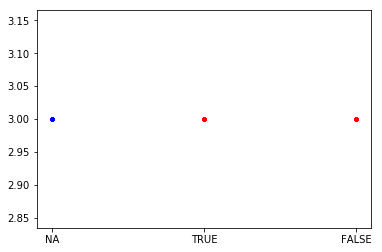